# Deciphering gene regulation through vector fields analysis in pancreatic endocrinogenesis

cellDancer could be integrated into downstream analysis, such as [dynamo](https://dynamo-release.readthedocs.io/en/latest/index.html) proposed by [Qiu et al.](https://www.sciencedirect.com/science/article/pii/S0092867421015774#!)

In this tutorial, the output of cellDancer ([PancreaticEndocrinogenesis_cellDancer_estimation.csv](PancreaticEndocrinogenesis_cellDancer_estimation.csv)) in pancreatic endocrinogenesis is transferred to adata as dynamo input. We apply dynamo to (1) perform vector field analysis and (2) detect gene regulation with Jacobian analysis.

## Import packages

To run the notebook locally, both cellDancer and dynamo are need. Refer [cellDancer](installation.html) and [dynamo](https://dynamo-release.readthedocs.io/en/latest/index.html) for instructions of building the packages.

In [1]:
import random
import numpy as np
import pandas as pd 
import numpy as np
import scipy
import warnings
warnings.filterwarnings('ignore')
import dynamo as dyn
from celldancer.utilities import export_velocity_to_dynamo

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


In [2]:
dyn.configuration.set_figure_params('dynamo', background='white')

## Input the prediction of cellDancer to dynamo

Import the cellDancer predicted RNA velocity to dynamo adata using the API `export_velocity_to_dynamo`.

In [3]:
# First create dynamo adata 
adata_dyn = dyn.sample_data.pancreatic_endocrinogenesis()
pancreas_genes = ["Hes1","Nkx6-1","Nkx2-2","Neurog3","Neurod1","Pax4","Pax6","Arx","Pdx1","Ins1","Ins2","Ghrl","Ptf1a","Iapp","Isl1", "Sox9","Gcg"]
dyn.pp.recipe_monocle(adata_dyn, n_top_genes=4000, fg_kwargs={"shared_count": 20}, genes_to_append=pancreas_genes)
dyn.tl.dynamics(adata_dyn, model='static') 

# replace adata.layers['velocity_S'], adata.var['use_for_dynamics'], and adata.var['use_for_transition'] with cellDancer outputs.
cellDancer_df = pd.read_csv('your_path/PancreaticEndocrinogenesis_cellDancer_estimation.csv')
adata = export_velocity_to_dynamo(cellDancer_df,adata_dyn)

|-----> Downloading data to ./data/endocrinogenesis_day15.h5ad
|-----> recipe_monocle_keep_filtered_cells_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_cells_key=True
|-----> recipe_monocle_keep_filtered_genes_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_filtered_genes_key=True
|-----> recipe_monocle_keep_raw_layers_key is None. Using default value from DynamoAdataConfig: recipe_monocle_keep_raw_layers_key=True
|-----> apply Monocole recipe to adata...
|-----> <insert> pp to uns in AnnData Object.
|-----------> <insert> has_splicing to uns['pp'] in AnnData Object.
|-----------> <insert> has_labling to uns['pp'] in AnnData Object.
|-----------> <insert> splicing_labeling to uns['pp'] in AnnData Object.
|-----------> <insert> has_protein to uns['pp'] in AnnData Object.
|-----> ensure all cell and variable names unique.
|-----> ensure all data in different layers in csr sparse matrix format.
|-----> ensure all labelin

## Project RNA velocity onto the embedding space

The projection of RNA velocity imported from cellDancer onto the embedding space was done by using dynamo method `cell_velocities()`

|-----> retrive data for non-linear dimension reduction...
|-----? adata already have basis umap. dimension reduction umap will be skipped! 
set enforce=True to re-performing dimension reduction.
|-----> [dimension_reduction projection] in progress: 100.0000%
|-----> [dimension_reduction projection] finished [0.0039s]
|-----> 0 genes are removed because of nan velocity values.
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] in progress: 100.0000%
|-----> [calculating transition matrix via pearson kernel with sqrt transform.] finished [14.3924s]
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector to low dimensional embedding] finished [1.0276s]
|-----> 0 genes are removed because of nan velocity values.
Using existing pearson_transition_matrix found in .obsp.
|-----> [projecting velocity vector to low dimensional embedding] in progress: 100.0000%
|-----> [projecting velocity vector t

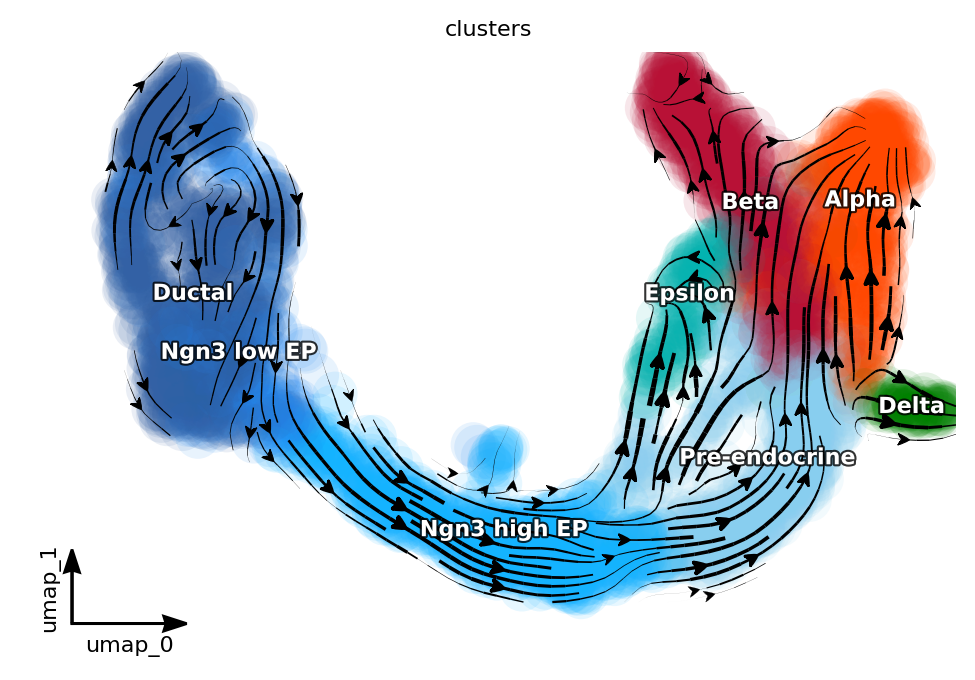

In [4]:
pancreas_cluster_cmap = {'Ductal': '#3361A5','Ngn3 low EP': '#248AF3','Ngn3 high EP': '#14B3FF','Pre-endocrine': '#88CEEF','Alpha': '#ff4800','Beta': '#B81136','Delta': 'green','Epsilon': '#03B3B0'}

dyn.tl.reduceDimension(adata, n_pca_components=30)
dyn.tl.cell_velocities(adata, method="pearson", other_kernels_dict={"transform": "sqrt"})
dyn.tl.cell_velocities(adata, basis="pca")

dyn.pl.streamline_plot(adata, color=["clusters"], basis="umap", color_key = pancreas_cluster_cmap, show_legend="on data", show_arrowed_spines=True)

## Learn the vector fields

Use dynamo to learn and visualize the vector fields on UMAP.

In [5]:
dyn.vf.VectorField(adata, basis="pca", pot_curl_div=True)
dyn.vf.VectorField(adata, basis="umap", pot_curl_div=True)

dyn.vf.speed(adata, basis="pca")
dyn.vf.divergence(adata, basis="pca")
dyn.vf.acceleration(adata, basis="pca")
dyn.vf.curl(adata, basis="umap")

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: PCA. 
        Vector field will be learned in the PCA space.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3184s]
|-----> <insert> velocity_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_pca_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_pca to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in pca basis...
|-----> graphizing vectorfield...
|-----> incomplete neighbor graph info detected: connectivities and distances do not exist in adata.obsp, indices not in adata.uns.neighbors.
|-----> Neighbor graph is broken, recomputing....
|-----> Start computing neighbor graph...
|-----------> X_data is None, fetching or recomputing...
|-----> fetching X data from la

Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00,  9.94it/s]

|-----> <insert> control_point_pca to obs in AnnData Object.
|-----> <insert> inlier_prob_pca to obs in AnnData Object.


|-----> <insert> obs_vf_angle_pca to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [21.5317s]
|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: UMAP. 
        Vector field will be learned in the UMAP space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.4374s]
|-----> <insert> velocity_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_umap_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_umap to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in umap basis...
|-----> graphizing vectorfield...
|-----------? nbrs_idx argument is ignored and recomputed because nbrs_idx is not None and retur

Calculating 2-D curl: 100%|██████████████| 3696/3696 [00:00<00:00, 15543.98it/s]

|-----> Computing divergence...



Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00, 23.67it/s]

|-----> <insert> control_point_umap to obs in AnnData Object.
|-----> <insert> inlier_prob_umap to obs in AnnData Object.


|-----> <insert> obs_vf_angle_umap to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [19.8864s]


Calculating divergence: 100%|█████████████████████| 4/4 [00:00<00:00, 10.07it/s]


|-----> [Calculating acceleration] in progress: 100.0000%
|-----> [Calculating acceleration] finished [0.1751s]
|-----> <insert> acceleration to layers in AnnData Object.


Calculating 2-D curl: 100%|██████████████| 3696/3696 [00:00<00:00, 17567.05it/s]


|-----> Vector field for umap is but its topography is not mapped. Mapping topography now ...
|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


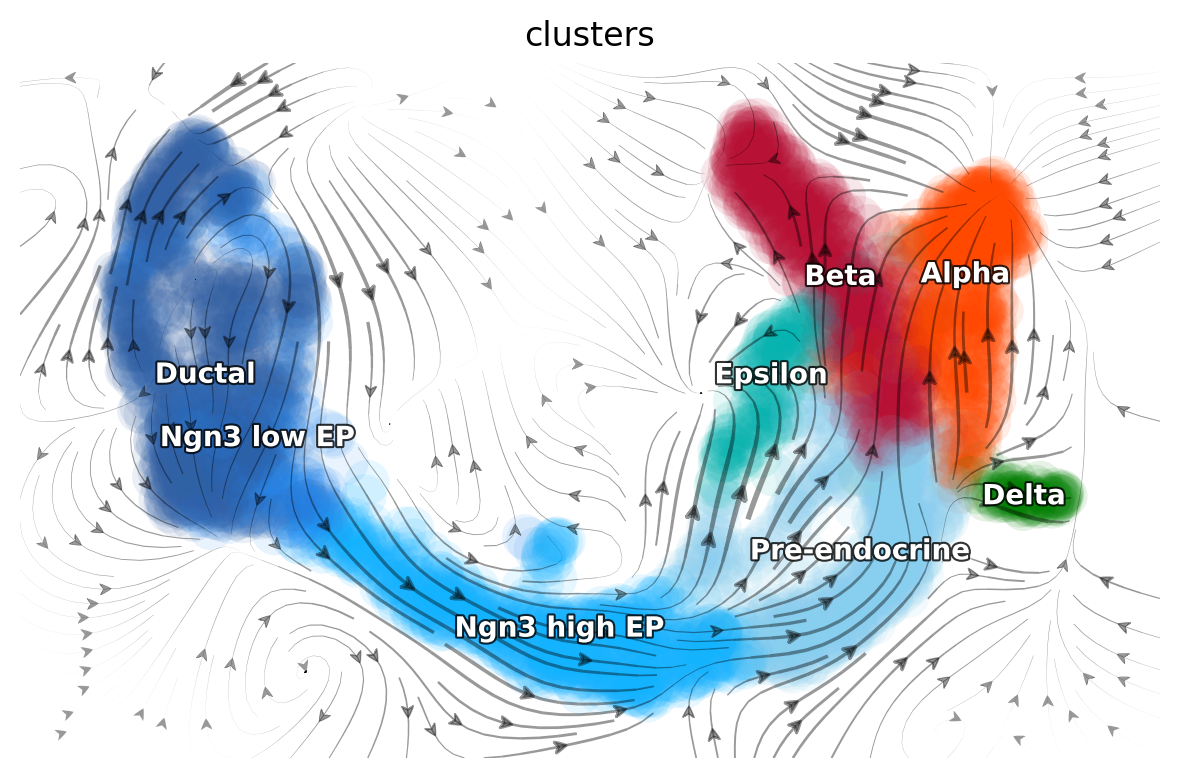

In [6]:
dyn.pl.topography(adata, color=['clusters'], basis='umap', background='white', 
                  streamline_color='black', color_key = pancreas_cluster_cmap, show_legend='on data', terms=("streamline"))

The emitting fixed point #0 is identified in ductal cells. The absorbing fixed points #1 #2 #3 are identified in Alpha-, Beta-, and Epsilon-cells.

|-----------> plotting with basis key=X_umap
|-----------> skip filtering clusters by stack threshold when stacking color because it is not a numeric type


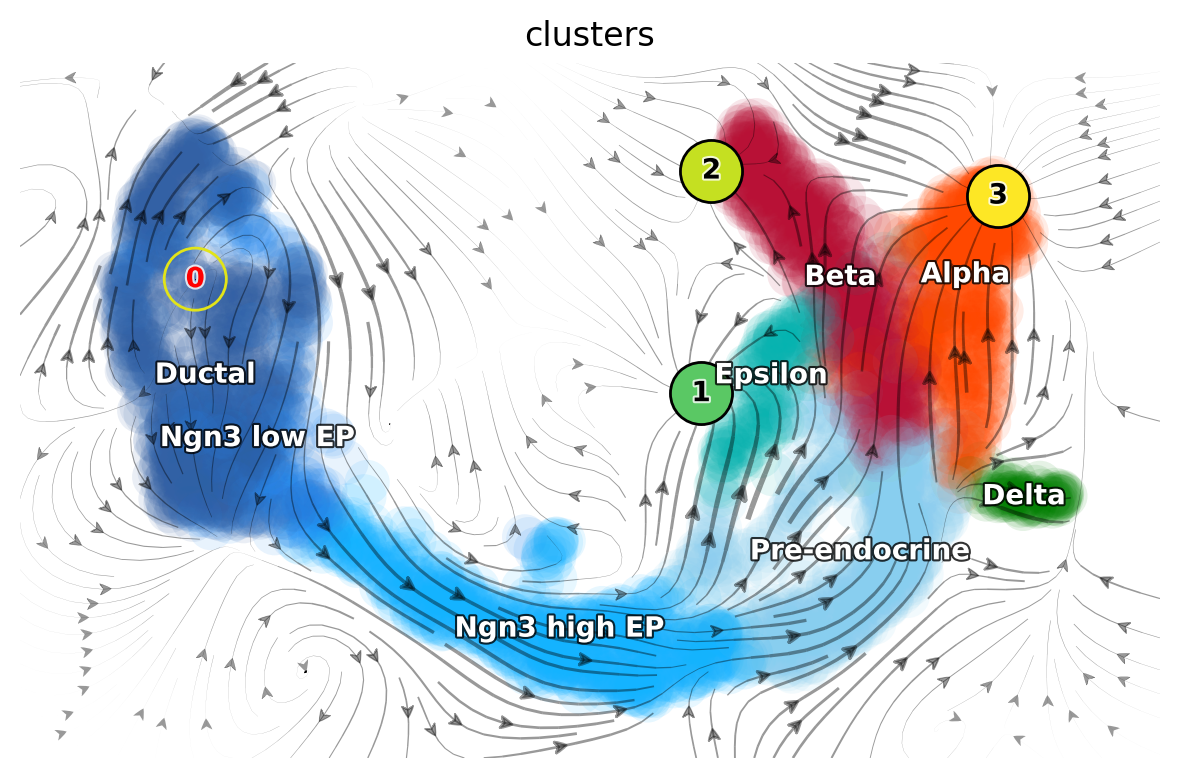

In [7]:
adata_load_fix_points=adata.copy()
Xss, ftype, conf = adata_load_fix_points.uns['VecFld_umap']['Xss'],\
                   adata_load_fix_points.uns['VecFld_umap']['ftype'],\
                   adata_load_fix_points.uns['VecFld_umap']['confidence']
    
fixed_points = [10,7,16,12]

adata_load_fix_points.uns['VecFld_umap']['Xss'] = Xss[fixed_points]
adata_load_fix_points.uns['VecFld_umap']['ftype'] = ftype[fixed_points]
adata_load_fix_points.uns['VecFld_umap']['confidence']=conf[fixed_points]

dyn.pl.topography(
    adata_load_fix_points,
    markersize=500,
    basis="umap",
    fps_basis="umap",
    color_key = pancreas_cluster_cmap, 
    color=["clusters"],
    show_legend='on data',    
    save_show_or_return='show'
)

## Jacobian analysis 

Jacobian analysis shows that Pax4 is down-regulated by Arx in the Alpha-cells; Arx is down-regulated by Pax4 in the Beta-cells.

Transforming subset Jacobian: 100%|██████| 3696/3696 [00:00<00:00, 98024.28it/s]


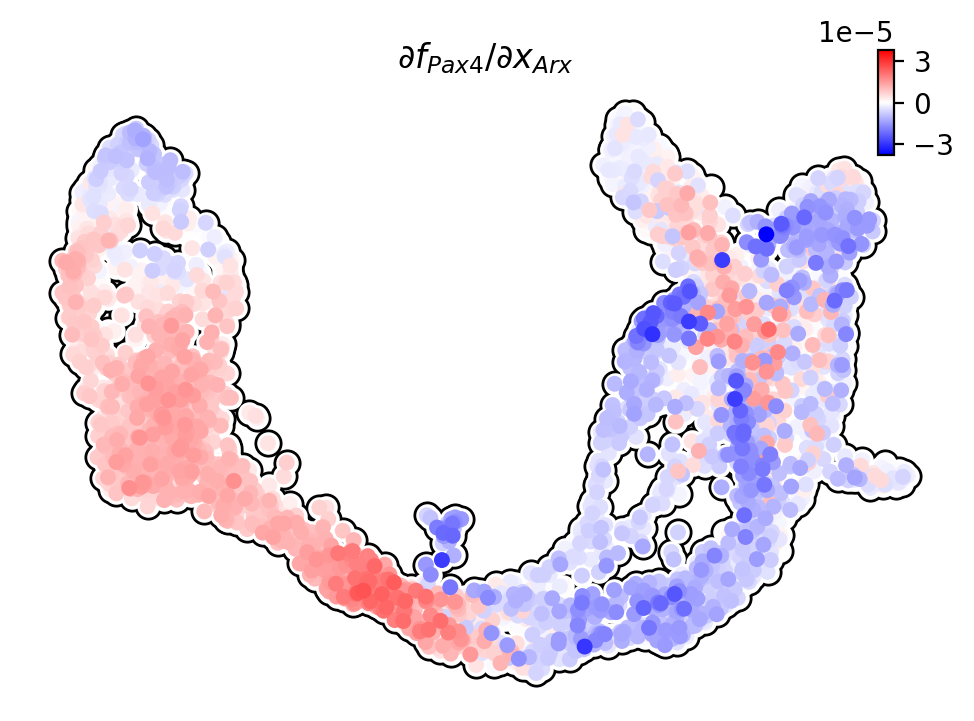

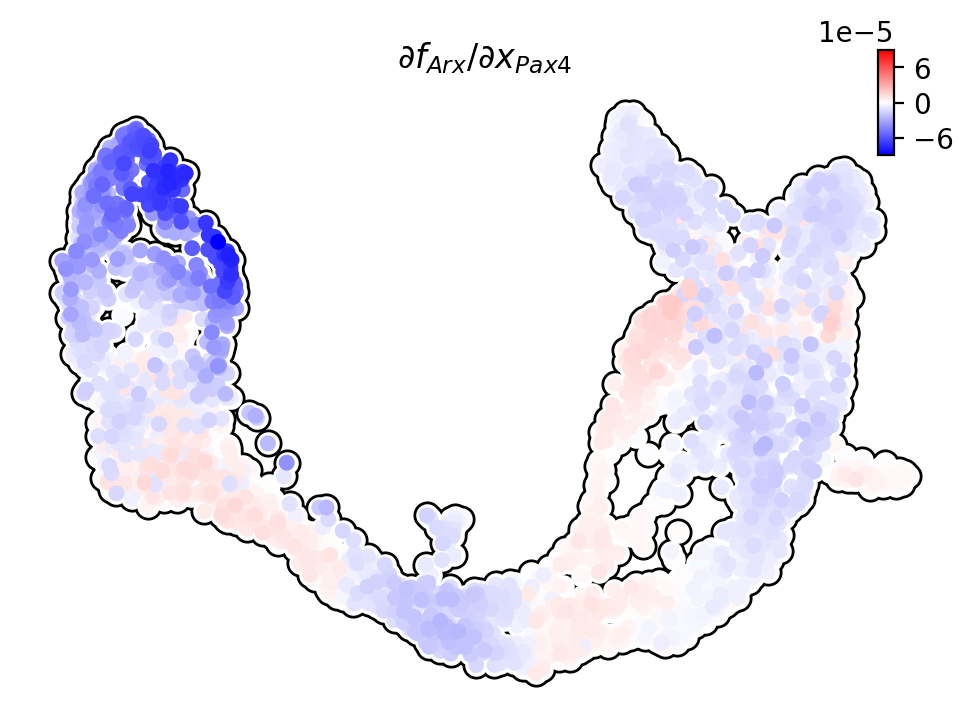

In [8]:
dyn.vf.jacobian(adata, regulators=['Arx','Pax4'])

dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=['Arx'],
    effectors=['Pax4'],
    alpha=1,
)

dyn.pl.jacobian(
    adata,
    basis="umap",
    regulators=['Pax4'],
    effectors=['Arx'],
    alpha=1,
)

Visualize the expression levels of Arx and Pax4 on UMAP. 

|-----------> plotting with basis key=X_umap


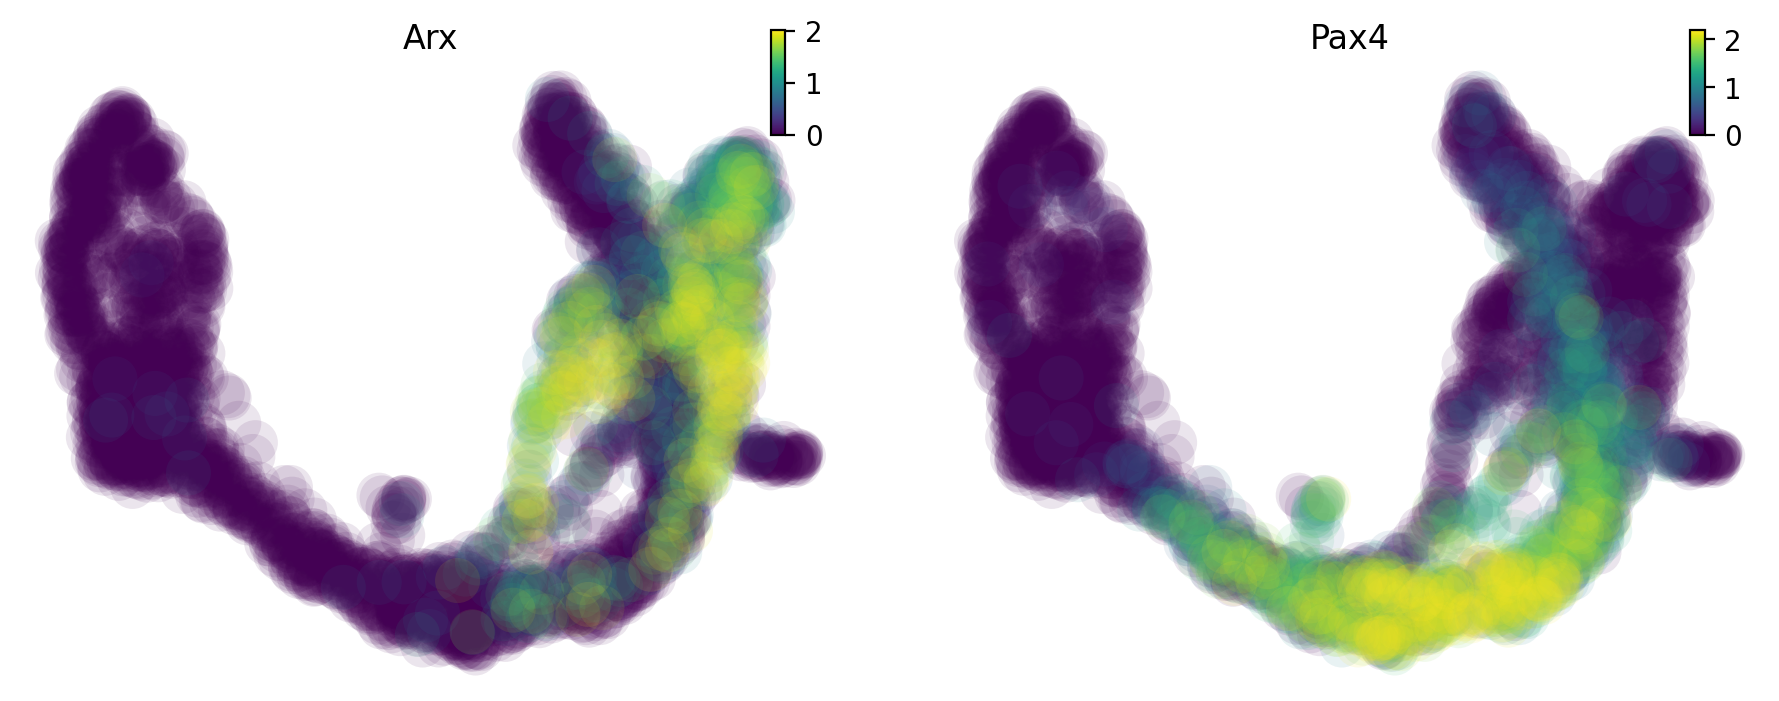

In [9]:
dyn.pl.umap(adata,  color=["Arx",'Pax4'],save_show_or_return='show')